In [1]:
!pip install timm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import timm
import os
import zipfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()

In [3]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform = get_transforms()

# Load dataset
def load_dataset(dataset_path, transform):
    class_names = ['fresh', 'stale']
    dataset = ImageFolder(root=dataset_path, transform=transform)
    dataset.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    dataset.samples = [(path, dataset.class_to_idx[os.path.basename(os.path.dirname(path))]) for path, _ in dataset.samples]
    return dataset

dataset_path = "/kaggle/input/apple-orange-banana"
dataset = load_dataset(dataset_path, transform)

In [4]:
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size])

train_dataset, test_dataset = split_dataset(dataset)

In [5]:
def get_data_loaders(train_dataset, test_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = get_data_loaders(train_dataset, test_dataset)

In [8]:
import torch
import torch.nn as nn

# Configuration
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = 768  # Standard ViT base config
NUM_OF_PATCHES = (IMAGE_WIDTH * IMAGE_HEIGHT) // (PATCH_SIZE ** 2)


# Patch Embedding Layer
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim,
                                    kernel_size=patch_size, stride=patch_size)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.position_embeddings = nn.Parameter(torch.randn(1, NUM_OF_PATCHES + 1, embedding_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv_layer(x)  # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        class_token = self.class_token.expand(batch_size, -1, -1)  # (B, 1, E)
        x = torch.cat((class_token, x), dim=1)  # (B, N+1, E)
        x = x + self.position_embeddings  # add positional encoding
        return x


# Multi-Head Self Attention Block
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dims=768, num_heads=12, attn_dropout=0.0):
        super().__init__()
        self.layernorm = nn.LayerNorm(embedding_dims)
        self.multiheadattention = nn.MultiheadAttention(embed_dim=embedding_dims,
                                                        num_heads=num_heads,
                                                        dropout=attn_dropout,
                                                        batch_first=True)

    def forward(self, x):
        norm_x = self.layernorm(x)
        attn_output, _ = self.multiheadattention(norm_x, norm_x, norm_x)
        return x + attn_output  # residual connection


# MLP Block
class MachineLearningPerceptronBlock(nn.Module):
    def __init__(self, embedding_dims, mlp_size, mlp_dropout):
        super().__init__()
        self.layernorm = nn.LayerNorm(embedding_dims)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dims, mlp_size),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_size, embedding_dims),
            nn.Dropout(mlp_dropout)
        )

    def forward(self, x):
        return x + self.mlp(self.layernorm(x))  # residual connection


# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dims=768, mlp_dropout=0.1, attn_dropout=0.0, mlp_size=3072, num_heads=12):
        super().__init__()
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims, num_heads, attn_dropout)
        self.mlp_block = MachineLearningPerceptronBlock(embedding_dims, mlp_size, mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x)
        x = self.mlp_block(x)
        return x


# Vision Transformer
class ViT(nn.Module):
    def __init__(self, img_size=224, in_channels=3, patch_size=16, embedding_dims=768,
                 num_transformer_layers=12, mlp_dropout=0.1, attn_dropout=0.0,
                 mlp_size=3072, num_heads=12, num_classes=1000):
        super().__init__()

        self.patch_embedding_layer = PatchEmbeddingLayer(in_channels=in_channels,
                                                         patch_size=patch_size,
                                                         embedding_dim=embedding_dims)

        self.transformer_encoder = nn.Sequential(*[
            TransformerBlock(embedding_dims, mlp_dropout, attn_dropout, mlp_size, num_heads)
            for _ in range(num_transformer_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dims),
            nn.Linear(embedding_dims, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding_layer(x)
        x = self.transformer_encoder(x)
        x = x[:, 0]  # take class token
        x = self.classifier(x)
        return x



# import torch
# import torch.nn as nn

# # Patch Embedding Layer
# class PatchEmbedding(nn.Module):
#     def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_dim=768):
#         super().__init__()
#         self.patch_size = patch_size
#         self.num_patches = (img_size // patch_size) ** 2
#         self.embedding_dim = embedding_dim

#         self.projection = nn.Conv2d(
#             in_channels, embedding_dim, 
#             kernel_size=patch_size, stride=patch_size
#         )

#         self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))
#         self.position_embeddings = nn.Parameter(torch.zeros(1, self.num_patches + 1, embedding_dim))

#     def forward(self, x):
#         batch_size = x.shape[0]

#         # Shape: [batch_size, embedding_dim, num_patches_h, num_patches_w]
#         x = self.projection(x)

#         # Flatten patches
#         x = x.flatten(2)  # [batch_size, embedding_dim, num_patches]
#         x = x.transpose(1, 2)  # [batch_size, num_patches, embedding_dim]

#         # Add class token
#         class_token = self.class_token.expand(batch_size, -1, -1)  # [batch_size, 1, embedding_dim]
#         x = torch.cat((class_token, x), dim=1)  # [batch_size, num_patches+1, embedding_dim]

#         # Add positional encoding
#         x = x + self.position_embeddings

#         return x

# # Multi-Head Self-Attention
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, embedding_dim=768, num_heads=12, dropout=0.0):
#         super().__init__()
#         self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

#     def forward(self, x):
#         attn_output, _ = self.mha(x, x, x)
#         return attn_output

# # Transformer Encoder Block
# class TransformerEncoderBlock(nn.Module):
#     def __init__(self, embedding_dim=768, num_heads=12, mlp_dim=3072, attn_dropout=0.0, mlp_dropout=0.1):
#         super().__init__()
#         self.norm1 = nn.LayerNorm(embedding_dim)
#         self.mha = MultiHeadSelfAttention(embedding_dim, num_heads, attn_dropout)
#         self.norm2 = nn.LayerNorm(embedding_dim)

#         self.mlp = nn.Sequential(
#             nn.Linear(embedding_dim, mlp_dim),
#             nn.GELU(),
#             nn.Dropout(mlp_dropout),
#             nn.Linear(mlp_dim, embedding_dim),
#             nn.Dropout(mlp_dropout)
#         )

#     def forward(self, x):
#         x = x + self.mha(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))
#         return x

# # Full ViT Model
# class ViT(nn.Module):
#     def __init__(
#         self,
#         img_size=224,
#         patch_size=16,
#         in_channels=3,
#         embedding_dims=768,
#         num_heads=12,
#         mlp_size=3072,
#         num_transformer_layers=12,
#         attn_dropout=0.0,
#         mlp_dropout=0.1,
#         num_classes=2
#     ):
#         super().__init__()

#         self.patch_embedding_layer = PatchEmbedding(
#             img_size=img_size,
#             patch_size=patch_size,
#             in_channels=in_channels,
#             embedding_dim=embedding_dims
#         )

#         self.transformer_encoder = nn.Sequential(
#             *[TransformerEncoderBlock(
#                 embedding_dim=embedding_dims,
#                 num_heads=num_heads,
#                 mlp_dim=mlp_size,
#                 attn_dropout=attn_dropout,
#                 mlp_dropout=mlp_dropout
#             ) for _ in range(num_transformer_layers)]
#         )

#         self.classifier = nn.Linear(embedding_dims, num_classes)

#     def forward(self, x):
#         x = self.patch_embedding_layer(x)
#         x = self.transformer_encoder(x)
#         x = self.classifier(x[:, 0])  # Only class token
#         return x


In [9]:
def load_model(device):
    model = ViT(
        img_size=224,
        patch_size=16,
        in_channels=3,
        embedding_dims=768,
        num_heads=12,
        mlp_size=3072,
        num_transformer_layers=12,
        attn_dropout=0.0,
        mlp_dropout=0.1,
        num_classes=2
    )
    return model.to(device)

model = load_model(device)


In [10]:
def get_loss_and_optimizer(model, lr=1e-4, weight_decay=1e-2):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    return criterion, optimizer

criterion, optimizer = get_loss_and_optimizer(model)

In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        test_acc = evaluate_model(model, test_loader)
        print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [12]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1: Loss=0.5906, Train Acc=72.32%, Test Acc=85.26%
Epoch 2: Loss=0.3724, Train Acc=88.72%, Test Acc=87.93%
Epoch 3: Loss=0.3352, Train Acc=91.52%, Test Acc=92.46%
Epoch 4: Loss=0.3219, Train Acc=92.68%, Test Acc=93.10%
Epoch 5: Loss=0.3010, Train Acc=93.97%, Test Acc=94.43%
Epoch 6: Loss=0.2929, Train Acc=94.20%, Test Acc=94.23%
Epoch 7: Loss=0.2932, Train Acc=94.28%, Test Acc=93.05%
Epoch 8: Loss=0.2841, Train Acc=95.02%, Test Acc=95.47%
Epoch 9: Loss=0.2719, Train Acc=95.85%, Test Acc=95.22%
Epoch 10: Loss=0.2718, Train Acc=95.61%, Test Acc=96.60%


['fresh', 'stale']


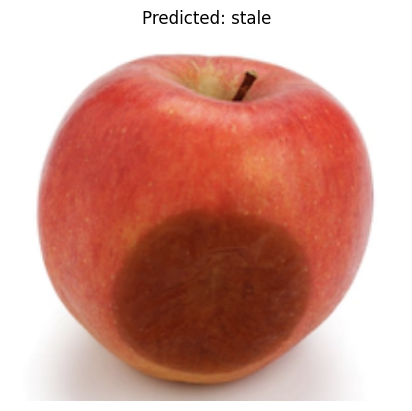

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['fresh','stale']
print(class_names)


def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(transformed)
        _, predicted = output.max(1)

    predicted_label = class_names[predicted.item()]


    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

test_image_path = "/kaggle/input/apple-orange-banana/custom_fruits/stale/Screen Shot 2018-06-07 at 2.34.18 PM.png"
predict_image(test_image_path)

In [14]:
save_path="/kaggle/working/apple_banana_orange_vit_scratch.pth"
torch.save(model.state_dict(), save_path)

print(f"Model parameters saved to {save_path}")

Model parameters saved to /kaggle/working/apple_banana_orange_vit_scratch.pth
